<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models</h4>
    <p style="font-size: 20px;">NBA API Data (1984-2024)</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)
  
**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Setup](#1.1.-Setup)

- [1.2. Time Series Cross-Validation](#1.2.-Time-Series-Cross-Validation)

- [1.3. Manual Rolling Window](#1.3.-Manual-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Baseline-Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

In [2]:
team_bs_matchups_roll_df = pd.read_csv('../data/processed/nba_team_matchups_rolling_stats_1984_2024_r05.csv')

# convert 'GAME_DATE' column to datetime
team_bs_matchups_roll_df['GAME_DATE'] = pd.to_datetime(team_bs_matchups_roll_df['GAME_DATE'])

In [3]:
team_bs_matchups_roll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52101 entries, 0 to 52100
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SEASON_ID               52101 non-null  int64         
 1   HOME_TEAM_ID            52101 non-null  int64         
 2   HOME_TEAM_ABBREVIATION  52101 non-null  object        
 3   HOME_TEAM_NAME          52101 non-null  object        
 4   GAME_ID                 52101 non-null  int64         
 5   GAME_DATE               52101 non-null  datetime64[ns]
 6   HOME_WL                 52098 non-null  object        
 7   HOME_MIN                52101 non-null  int64         
 8   HOME_PTS                52101 non-null  int64         
 9   HOME_FGM                52101 non-null  int64         
 10  HOME_FGA                52101 non-null  int64         
 11  HOME_FG_PCT             52101 non-null  float64       
 12  HOME_FG3M               52101 non-null  int64 

In [4]:
team_bs_matchups_roll_df.head()

,SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,GAME_ID,GAME_DATE,HOME_WL,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,...,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS
0,21983,1610612737,ATL,Atlanta Hawks,28300014,1983-10-29,W,240,117,49,94,0.521,0,1.0,0.0,19,30,0.633,27.0,21.0,48.0,28,14.0,7,23,...,NaN,NaN,NaN,NaN,NaN,240.000,115.400,43.000,84.8,0.507,10.000,28.2,0.355,19.400,24.6,0.785,11.6,31.000,42.600,25.200,6.200,5.000,11.0,17.200,-0.8
1,21983,1610612737,ATL,Atlanta Hawks,28300027,1983-11-01,W,240,95,38,81,0.469,0,0.0,NaN,19,30,0.633,12.0,29.0,41.0,20,7.0,10,16,...,14.000,7.0,23.00,35.0,NaN,240.000,105.500,39.000,81.5,0.478,0.000,2.0,0.000,27.500,35.0,0.782,12.5,30.500,43.000,26.500,8.500,3.000,22.0,33.500,NaN
2,21983,1610612737,ATL,Atlanta Hawks,28300041,1983-11-04,W,240,103,42,86,0.488,1,1.0,1.0,18,26,0.692,19.0,27.0,46.0,31,14.0,13,18,...,10.500,8.5,19.50,34.5,NaN,240.000,99.000,37.000,99.5,0.373,1.500,4.5,0.375,23.500,31.0,0.754,20.0,27.000,47.000,18.500,10.500,6.500,18.5,30.500,NaN
3,21983,1610612737,ATL,Atlanta Hawks,28300101,1983-11-15,W,240,107,45,84,0.536,0,0.0,NaN,17,21,0.810,17.0,24.0,41.0,24,7.0,10,18,...,11.667,10.0,19.00,32.0,NaN,247.400,113.600,46.800,96.0,0.488,0.600,2.0,0.250,19.400,28.2,0.691,15.8,27.400,43.200,25.200,10.600,4.200,16.8,26.600,NaN
4,21983,1610612737,ATL,Atlanta Hawks,28300112,1983-11-17,W,240,99,35,66,0.530,1,2.0,0.5,28,40,0.700,10.0,35.0,45.0,20,5.0,12,23,...,10.500,10.0,18.75,30.5,NaN,248.333,119.667,44.667,88.0,0.508,0.667,1.0,0.750,29.667,40.0,0.742,16.0,27.667,43.667,26.667,11.667,6.667,20.0,25.667,NaN


In [5]:
team_bs_matchups_roll_df.describe()

,SEASON_ID,HOME_TEAM_ID,GAME_ID,GAME_DATE,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PLUS_MINUS,AWAY_TEAM_ID,...,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS
count,52101.000,5.210e+04,5.210e+04,52101,52101.000,52101.000,52101.000,52101.000,52101.000,52101.00,52100.000,51484.000,52101.000,52101.000,52099.000,52098.000,52098.000,52101.000,52101.000,52100.000,52101.000,52101.000,52101.000,37261.000,5.210e+04,...,52100.000,52100.000,52100.000,52100.000,37572.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52093.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,37573.000
mean,22881.387,1.611e+09,5.805e+07,2005-02-11 14:31:23.434099200,240.466,103.698,38.866,83.498,0.466,6.29,17.681,0.343,19.676,25.997,0.757,12.095,31.263,43.359,23.642,7.979,5.301,14.395,21.615,2.819,1.611e+09,...,7.982,5.302,14.403,21.625,2.798,240.449,100.410,37.767,83.319,0.454,6.163,17.699,0.334,18.713,24.804,0.755,11.688,30.115,41.805,21.911,7.839,4.685,14.807,22.403,-2.838
min,12003.000,1.611e+09,1.030e+07,1983-10-28 00:00:00,-1.000,0.000,0.000,1.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-68.000,1.611e+09,...,2.600,0.600,5.600,11.200,-32.000,60.000,61.000,23.200,54.200,0.337,0.000,0.000,0.000,7.000,9.400,0.490,4.400,16.400,28.000,5.000,2.400,0.800,6.800,11.800,-33.000
25%,21994.000,1.611e+09,2.090e+07,1995-04-02 00:00:00,240.000,94.000,35.000,78.000,0.425,3.00,10.000,0.256,15.000,20.000,0.696,9.000,27.000,39.000,20.000,6.000,3.000,11.000,18.000,-7.000,1.611e+09,...,6.800,4.200,12.800,19.600,-2.200,240.000,94.000,35.000,79.200,0.433,3.400,10.400,0.298,16.200,21.600,0.722,9.800,27.800,39.400,19.600,6.800,3.800,13.000,20.200,-7.600
50%,22005.000,1.611e+09,2.200e+07,2005-12-28 00:00:00,240.000,103.000,39.000,83.000,0.465,6.00,16.000,0.345,19.000,25.000,0.763,12.000,31.000,43.000,23.000,8.000,5.000,14.000,21.000,4.000,1.611e+09,...,7.800,5.200,14.200,21.400,3.000,240.000,100.000,37.600,83.200,0.453,5.800,16.600,0.341,18.400,24.600,0.756,11.600,30.000,41.800,21.800,7.800,4.600,14.600,22.200,-2.800
75%,22015.000,1.611e+09,2.920e+07,2015-01-02 00:00:00,240.000,113.000,43.000,89.000,0.506,9.00,24.000,0.429,24.000,31.000,0.825,15.000,35.000,48.000,27.000,10.000,7.000,17.000,25.000,11.000,1.611e+09,...,9.000,6.200,16.000,23.400,7.800,241.000,106.600,40.400,87.400,0.474,8.600,23.800,0.381,21.000,27.800,0.791,13.200,32.200,44.200,24.200,8.800,5.600,16.400,24.400,1.800
max,62023.000,1.611e+09,1.622e+09,2024-01-21 00:00:00,688.000,184.000,68.000,135.000,0.833,28.00,70.000,2.000,61.000,80.000,1.000,37.000,55.000,77.000,50.000,27.000,23.000,39.000,45.000,73.000,1.611e+09,...,18.000,15.500,26.000,37.000,31.800,282.600,138.600,55.000,116.400,0.583,20.600,53.200,1.000,51.000,53.000,1.000,26.500,47.400,57.400,37.200,15.800,13.000,29.000,42.200,29.600
std,5186.768,8.567e+00,2.191e+08,NaN,12.120,14.052,6.116,8.783,0.059,4.47,10.747,0.156,6.795,8.419,0.099,4.433,5.656,6.879,5.736,3.099,2.759,4.152,4.730,13.416,8.571e+00,...,1.720,1.627,2.354,2.878,7.363,6.901,9.122,3.870,5.857,0.031,3.716,9.853,0.079,3.553,4.499,0.052,2.528,3.359,3.568,3.372,1.605,1.330,2.513,3.111,7.055


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Setup"></a>
## 1.1. Setup

[Return to top](#Baseline-Models)

In [6]:
# filter data to about 1 year
team_matchups_2023 = team_bs_matchups_roll_df[team_bs_matchups_roll_df['GAME_DATE'] >= '2023-01-01']

# feature columns
feature_names = [col for col in team_bs_matchups_roll_df.columns if col.startswith('ROLL_')] 
features = team_matchups_2023[feature_names]

# get target
target = team_matchups_2023['TOTAL_PTS'] 

# get column names
all_colnames = feature_names
all_colnames.append('TOTAL_PTS')

# min-max scaling for features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# recombine scaled features with the target
scaled_data = np.concatenate([scaled_features, target.values.reshape(-1, 1)], axis=1)

# convert scaled data back to DataFrame and reset index
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.columns = all_colnames
scaled_data_df = scaled_data_df.reset_index(drop=True)

In [7]:
scaled_data_df.head()

,ROLL_HOME_MIN,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,TOTAL_PTS
0,0.808,0.679,0.745,0.847,0.478,0.324,0.366,0.436,0.340,0.309,0.651,0.385,0.544,0.522,0.437,0.409,0.556,0.203,0.297,0.602,0.921,0.526,0.422,0.682,0.293,0.464,0.719,0.339,0.526,0.682,0.414,0.730,0.886,0.904,0.292,0.229,0.238,0.700,0.319,0.412,219.0
1,0.808,0.608,0.664,0.804,0.420,0.309,0.351,0.428,0.320,0.291,0.644,0.385,0.544,0.522,0.402,0.364,0.556,0.217,0.216,0.567,0.787,0.597,0.466,0.541,0.434,0.406,0.518,0.430,0.691,0.745,0.616,0.476,0.419,0.384,0.382,0.646,0.167,0.357,0.565,0.585,234.0
2,0.808,0.652,0.718,0.712,0.575,0.294,0.276,0.514,0.340,0.345,0.519,0.277,0.427,0.357,0.446,0.432,0.511,0.232,0.243,0.602,0.781,0.584,0.414,0.601,0.323,0.507,0.597,0.507,0.701,0.882,0.405,0.825,0.590,0.704,0.079,0.167,0.381,0.129,0.435,0.656,263.0
3,0.798,0.682,0.782,0.761,0.604,0.309,0.276,0.539,0.278,0.273,0.549,0.369,0.282,0.278,0.420,0.341,0.422,0.217,0.189,0.567,0.772,0.716,0.707,0.642,0.677,0.536,0.576,0.545,0.402,0.536,0.369,0.476,0.514,0.464,0.674,0.562,0.452,0.371,0.623,0.565,240.0
4,0.798,0.720,0.809,0.675,0.705,0.353,0.299,0.601,0.299,0.255,0.661,0.292,0.262,0.217,0.437,0.341,0.378,0.406,0.270,0.557,0.792,0.681,0.629,0.541,0.682,0.565,0.345,0.853,0.454,0.545,0.464,0.619,0.467,0.496,0.416,0.208,0.381,0.214,0.377,0.544,233.0


<a name="1.2.-Expanding-Window"></a>
## 1.2. Expanding Window

[Return to top](#Baseline-Models)

In [8]:
# feature columns
X = scaled_data_df.drop('TOTAL_PTS', axis=1)

# target column
y = scaled_data_df['TOTAL_PTS']

In [9]:
# initialize TimeSeriesSplit

# n_splits = 12 # roughly monthly
n_splits = len(X) - 1  # LOO
tscv = TimeSeriesSplit(n_splits=n_splits)

# inspect splits
counter = 0
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= 24:
        break

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
TRAIN: [0 1 2 3 4 5] TEST: [6]
TRAIN: [0 1 2 3 4 5 6] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8

In [57]:
# initialize model
glm = LinearRegression()

# storage for predictions and RMSE
predictions = []
rmse_scores = []

start_time = time.time()

# expanding window
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit model on training data and predict on test data
    glm.fit(X_train, y_train)
    prediction = glm.predict(X_test)
    predictions.append(prediction[0])
    
    # evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    rmse_scores.append(rmse)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 5.54 seconds


In [58]:
# get average MSE over all splits
average_rmse = np.mean(rmse_scores[100:])
average_rmse_text = f"Average RMSE: {average_rmse:.2f}"
print(average_rmse_text)

Average RMSE: 17.85


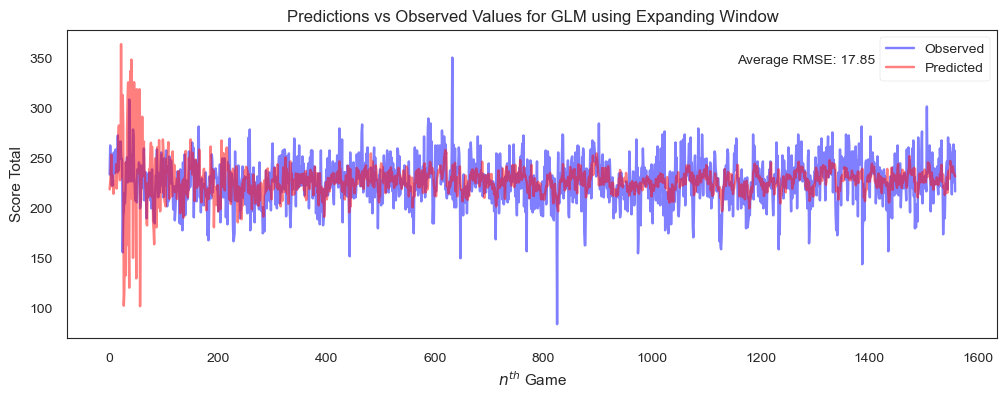

In [59]:
# get observations
observed_values = y.iloc[1:]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for GLM using Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=average_rmse_text, transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.3.-Rolling-Window"></a>
## 1.3. Rolling Window

[Return to top](#Baseline-Models)

In [13]:
scaled_data_df.tail()

,ROLL_HOME_MIN,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS,TOTAL_PTS
1554,0.457,0.436,0.525,0.566,0.500,0.341,0.474,0.331,0.254,0.250,0.524,0.155,0.356,0.282,0.586,0.486,0.606,0.464,0.473,0.311,0.670,0.645,0.543,0.615,0.458,0.500,0.437,0.655,0.649,0.607,0.663,0.770,0.493,0.648,0.280,0.462,0.242,0.299,0.382,0.671,226.0
1555,0.457,0.421,0.529,0.570,0.509,0.376,0.485,0.387,0.168,0.170,0.476,0.155,0.336,0.266,0.630,0.495,0.606,0.493,0.485,0.277,0.348,0.561,0.598,0.393,0.661,0.466,0.275,0.782,0.374,0.289,0.724,0.321,0.372,0.278,0.425,0.769,0.586,0.338,0.476,0.847,264.0
1556,0.457,0.454,0.543,0.543,0.534,0.382,0.449,0.452,0.228,0.208,0.539,0.141,0.291,0.224,0.648,0.458,0.606,0.507,0.497,0.272,0.798,0.508,0.594,0.665,0.475,0.275,0.210,0.479,0.427,0.455,0.429,0.764,0.377,0.552,0.493,0.096,0.535,0.714,0.835,0.201,246.0
1557,0.541,0.513,0.601,0.570,0.578,0.471,0.515,0.548,0.193,0.142,0.602,0.106,0.275,0.195,0.718,0.467,0.606,0.479,0.455,0.266,0.685,0.384,0.553,0.764,0.381,0.315,0.461,0.244,0.199,0.178,0.423,0.461,0.451,0.426,0.763,0.519,0.566,0.461,0.182,0.286,258.0
1558,0.630,0.555,0.655,0.652,0.586,0.471,0.521,0.540,0.193,0.132,0.618,0.127,0.324,0.244,0.731,0.421,0.587,0.471,0.473,0.264,0.693,0.450,0.671,0.647,0.576,0.275,0.162,0.588,0.133,0.178,0.172,0.733,0.363,0.522,0.686,0.385,0.636,0.130,0.329,0.596,217.0


In [14]:
# inspect splits

train_size = 10
test_size = 1

counter = 0
max_splits_to_show = 25

for train_index, test_index in utl.rolling_window_ts_split(scaled_data_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]
TRAIN: [15 16 17 18 19 20 21 22 23 24] TEST: [25]
TRAIN: [16 17 18 19 20 21 22 23 24 25] TEST: [26]
TRAIN: [17 18 19 20 21 22 23 24 25 26] TEST: [27]
TRAIN: [18 19 20 21 22 23 24 25 26 27] TEST: [28]
TRAIN: [19 20 21 22 23 24 25 26 27 28] TEST: [29]
TRAIN: [20

In [48]:
start_time = time.time()

# define window size for training
train_size = 500 # 'window size'
test_size = 1  # LOO

# storage for predictions and RMSE scores
predictions = []
rmse_scores = []

# rolling window
for train_index, test_index in utl.rolling_window_ts_split(scaled_data_df, train_size, test_size):
    # training data for this window
    X_train = scaled_data_df.iloc[train_index].drop(columns='TOTAL_PTS')
    y_train = scaled_data_df.iloc[train_index]['TOTAL_PTS']

    # test data for this window
    X_test = scaled_data_df.iloc[test_index].drop(columns='TOTAL_PTS')
    y_test = scaled_data_df.iloc[test_index]['TOTAL_PTS']

    # train the GLM
    glm = LinearRegression()
    glm.fit(X_train, y_train)

    # predict the next value and store the prediction
    prediction = glm.predict(X_test)
    predictions.extend(prediction)

    # evaluate model for this prediction
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    rmse_scores.append(rmse)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 3.72 seconds


In [49]:
# calculate average RMSE over all predictions
average_rmse = np.mean(rmse_scores)
average_rmse_text = f"Average RMSE: {average_rmse:.2f}"
print(average_rmse_text)

Average RMSE: 17.81


With rolling averages from the last 5, 20, 50 games for each team:

- Window Size = 1: Average RMSE: 21.36, 21.3, 21.36
- Window Size = 3: Average RMSE: 20.35, 21.73, 23.34
- Window Size = 5: Average RMSE: 21.15, 23.24, 25.65
- Window Size = 10: Average RMSE: 25.38, 28.66, 33.35
- Window Size = 20: Average RMSE: 36.39, 42.17, 47.55
- Window Size = 30: Average RMSE: 66.28, 73.36, 73.57
- Window Size = 40: Average RMSE: 73.10, 77.86, 89.48
- Window Size = 50: Average RMSE: 36.69, 39.33, 45.99
- Window Size = 100: Average RMSE: 23.36, 25.12, 24.61
- Window Size = 250: Average RMSE: 19.07, 20.18, 20.01
- Window Size = 500: Average RMSE: 17.81, 18.48, 18.04

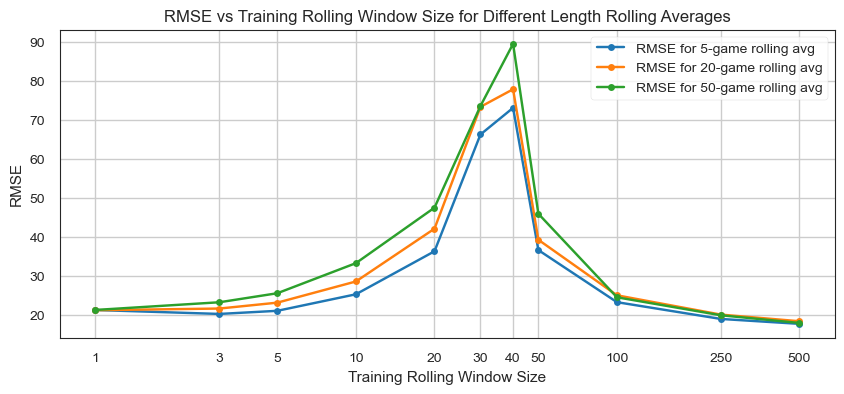

In [61]:
data = {
    "Window Size": [1, 3, 5, 10, 20, 30, 40, 50, 100, 250, 500],
    "RMSE_5_games": [21.36, 20.35, 21.15, 25.38, 36.39, 66.28, 73.10, 36.69, 23.36, 19.07, 17.81],
    "RMSE_20_games": [21.3, 21.73, 23.24, 28.66, 42.17, 73.36, 77.86, 39.33, 25.12, 20.18, 18.48],
    "RMSE_50_games": [21.36, 23.34, 25.65, 33.35, 47.55, 73.57, 89.48, 45.99, 24.61, 20.01, 18.04]
}
rmse_df = pd.DataFrame(data)

plt.figure(figsize=(10, 4))
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_5_games'], label='RMSE for 5-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_20_games'], label='RMSE for 20-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_50_games'], label='RMSE for 50-game rolling avg', marker='o', markersize=5)
plt.title('RMSE vs Training Rolling Window Size for Different Length Rolling Averages')
plt.xlabel('Training Rolling Window Size')
plt.ylabel('RMSE')
#plt.xticks(rmse_df['Window Size'])
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rmse_df['Window Size'], labels=rmse_df['Window Size'].astype(str))
plt.grid(True)
plt.legend()
plt.show()

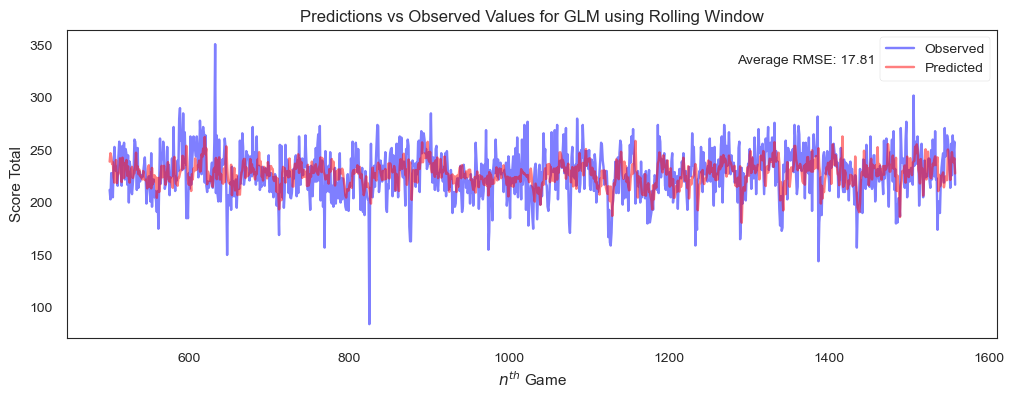

In [56]:
# observed values
observed_values = scaled_data_df['TOTAL_PTS'][train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = predictions[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for GLM using Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=average_rmse_text, transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)